In [ ]:
%pip install opencv-python
import cv2 
import numpy as np 
import pandas as pd
import os 
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt 

In [ ]:
# Function to apply Fourier Transform to an image 
def apply_fourier_transform(image):     
    f = np.fft.fft2(image)     
    fshift = np.fft.fftshift(f)     
    magnitude_spectrum = 20 * np.log(np.abs(fshift))     
    return magnitude_spectrum     

In [ ]:
# Load and preprocess images 
folder_path = r"C:\Users\91897\Desktop\Vinegar_eels\Center"
image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]  # or other image format  

# Set a fixed size for all images
fixed_size = (100, 200)  # Width x Height

In [ ]:
# Extract Fourier features 
fourier_features = [] 
image_labels = []  # To store labels and image indices
for index, file in enumerate(image_files):     
    image_path = os.path.join(folder_path, file)     
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale     
    image_resized = cv2.resize(image, fixed_size, interpolation=cv2.INTER_NEAREST)  # Resize image using nearest-neighbor method     
    transformed_image = apply_fourier_transform(image_resized)     
    fourier_features.append(transformed_image.flatten())  
    image_labels.append((index, file))  # Store image index and filename

Note: you may need to restart the kernel to use updated packages.


c:\Users\91897\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Labels assigned to images:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0]
    Cluster Label
0               0
1               0
2               0
3               0
4               0
..            ...
86              1
87              1
88              0
89              1
90              0

[91 rows x 1 columns]


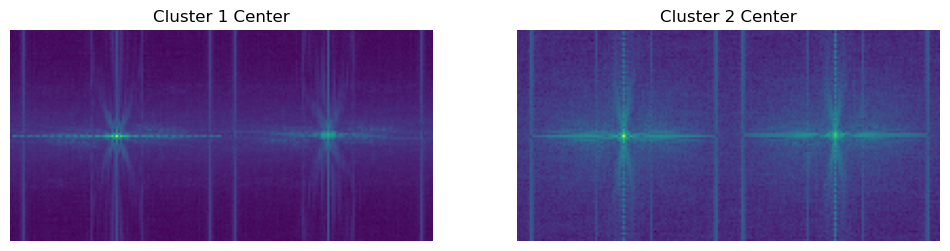

In [5]:
# Convert to numpy array 
fourier_features = np.array(fourier_features)  

# Apply K-Means Clustering 
n_clusters = 2  # Assuming we want to classify into 2 categories: inhibited and non-inhibited 
kmeans = KMeans(n_clusters=n_clusters, random_state=42) 
labels = kmeans.fit_predict(fourier_features)  

# Display results 
print("Labels assigned to images: ", labels)
# Create a DataFrame to display the results with indices
results = pd.DataFrame({
    # 'Index': range(len(image_files)),
    # 'Image Filename': image_files,
    'Cluster Label': labels
})

# Print the results
print(results)  

# # Create a dictionary to map image indices to cluster labels
# index_to_label = {i: labels[i] for i in range(len(labels))}

# # Visualize each image with its assigned cluster label
# for index, (img_index, file_name) in enumerate(image_labels):
#     plt.figure(figsize=(6, 4))
#     img_path = os.path.join(folder_path, file_name)
#     image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#     image_resized = cv2.resize(image, fixed_size, interpolation=cv2.INTER_NEAREST)
#     plt.imshow(image_resized, cmap='gray')
#     plt.title(f'Image {img_index}: Cluster {labels[img_index]}')
#     plt.axis('off')
#     plt.show()

# Visualize the cluster centroids 
plt.figure(figsize=(12, 6))
for i in range(n_clusters):
    plt.subplot(1, n_clusters, i + 1)
    plt.imshow(kmeans.cluster_centers_[i].reshape(fixed_size)) 
    plt.title(f'Cluster {i + 1} Center') 
    plt.axis('off')
plt.show()





In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from scipy.fft import fft
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping, Callback

# Load the dataset
image_folder = r"C:\Users\91897\Desktop\CP302\Speckle Images\C_1\Set1\Center"
csv_file = r"C:\Users\91897\Desktop\CP302\Center Results\Mean_speckle_contrast_values_Center.csv"

# Loading Y(Mean Speckle Contrast) values from CSV
df = pd.read_csv(csv_file)
Y_values = df.iloc[1:92, 4].values.astype(float)
Y = np.array([f"{value:.4f}" for value in Y_values], dtype=np.float32)
print('Mean Speckle Contrast values:', Y)
print('Number of Mean Speckle contrast values [Y]:', len(Y))

# Prepare input data X
resize = (918, 689)  # Define the desired size for all images (change as needed)
time_series_data = []

# Loop through the images in the specified folder
for image_file in sorted(os.listdir(image_folder)):
    image_path = os.path.join(image_folder, image_file)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is not None:
        img_resized = cv2.resize(img, resize)
        time_series_data.append(img_resized.flatten())  # Flatten and store each image

# Convert to NumPy array
time_series_data = np.array(time_series_data, dtype=np.float32)
print('Image pixel values over time:', time_series_data)
print('Shape of time series data:', time_series_data.shape)

# Apply Fourier Transform in the time domain
X_values = np.abs(fft(time_series_data, axis=0))
print('Fourier-transformed time domain data:', X_values)
print('Shape of Fourier-transformed data:', X_values.shape)

# Ensure compatibility between X and Y
if len(X_values) != len(Y):
    raise ValueError("Mismatch between the number of images and the number of Y values.")
else:
    print('Compatible shapes for X and Y')

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_values)

# Splitting data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_test:', y_test.shape)

# Callback for R² Score
class R2ScoreCallback(Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
    
    def on_epoch_end(self, epoch, logs=None):
        y_val_pred = self.model.predict(self.X_val)
        r2_val = r2_score(self.y_val, y_val_pred)
        print(f"Epoch {epoch+1}: R2 Val={r2_val:.3f}")

# Define the ANN model
def create_model(dropout_rate=0.0):
    model = Sequential([
        Dense(units=128, activation='relu', input_dim=X_train.shape[1]),
        Dropout(rate=dropout_rate),
        Dense(units=64, activation='relu'),
        Dropout(rate=dropout_rate),
        Dense(units=1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Wrapping the model with KerasRegressor
model = KerasRegressor(model=create_model, verbose=0, dropout_rate=0.0)

# Hyperparameter grid for tuning
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.0, 0.2, 0.4],
    'epochs': [50, 100],
    'batch_size': [16, 32]
}

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
r2_callback = R2ScoreCallback(X_test, y_test)

# Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
grid_result = grid.fit(X_train, y_train, callbacks=[early_stopping, r2_callback], validation_split=0.2)

# Best model from Grid Search
best_model = grid_result.best_estimator_
best_params = grid_result.best_params_
print("Best Parameters:", best_params)

# Predictions and Evaluation
y_pred = best_model.predict(X_test)
print('R2-score (test set): {:.3f}'.format(r2_score(y_test, y_pred)))
print('MSE (test set):', mean_squared_error(y_test, y_pred))
print('MAE (test set):', mean_absolute_error(y_test, y_pred))

# Plotting results
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Mean Speckle Contrast")
plt.ylabel("Predicted Mean Speckle Contrast")
plt.title("Actual vs Predicted Mean Speckle Contrast")
plt.show()


Mean Speckle Contrast values: [0.4965 0.4919 0.5042 0.5009 0.5315 0.4738 0.4847 0.4692 0.4959 0.5138
 0.5613 0.5041 0.4812 0.5241 0.4831 0.5119 0.4911 0.5579 0.5055 0.4866
 0.5636 0.612  0.5608 0.5212 0.5365 0.5665 0.6072 0.5531 0.5448 0.5182
 0.609  0.5202 0.4864 0.4963 0.5259 0.4912 0.5052 0.4589 0.5416 0.4742
 0.5021 0.5224 0.5877 0.5202 0.5017 0.4874 0.4514 0.5037 0.4743 0.507
 0.4678 0.4966 0.4807 0.4528 0.6209 0.5494 0.6117 0.5022 0.4401 0.4931
 0.4666 0.504  0.5204 0.4799 0.4876 0.4821 0.5098 0.4856 0.5016 0.4663
 0.4786 0.4465 0.434  0.4474 0.4699 0.4536 0.4895 0.5899 0.5396 0.4886
 0.4721 0.4673 0.491  0.5162 0.4459 0.5067 0.4663 0.4701 0.4537 0.4603
 0.5047]
Number of Mean Speckle contrast values [Y]: 91
Image pixel values over time: [[105. 105. 105. ...  64.  64.  64.]
 [105. 105. 105. ...  64.  64.  64.]
 [105. 105. 105. ...  64.  64.  64.]
 ...
 [105. 105. 105. ...  64.  64.  64.]
 [105. 105. 105. ...  64.  64.  64.]
 [105. 105. 105. ...  64.  64.  64.]]
Shape of time seri